### AIC, goodness of fit

Lloyd-Smith et al have provided a way to use AIC for goodness of fit:

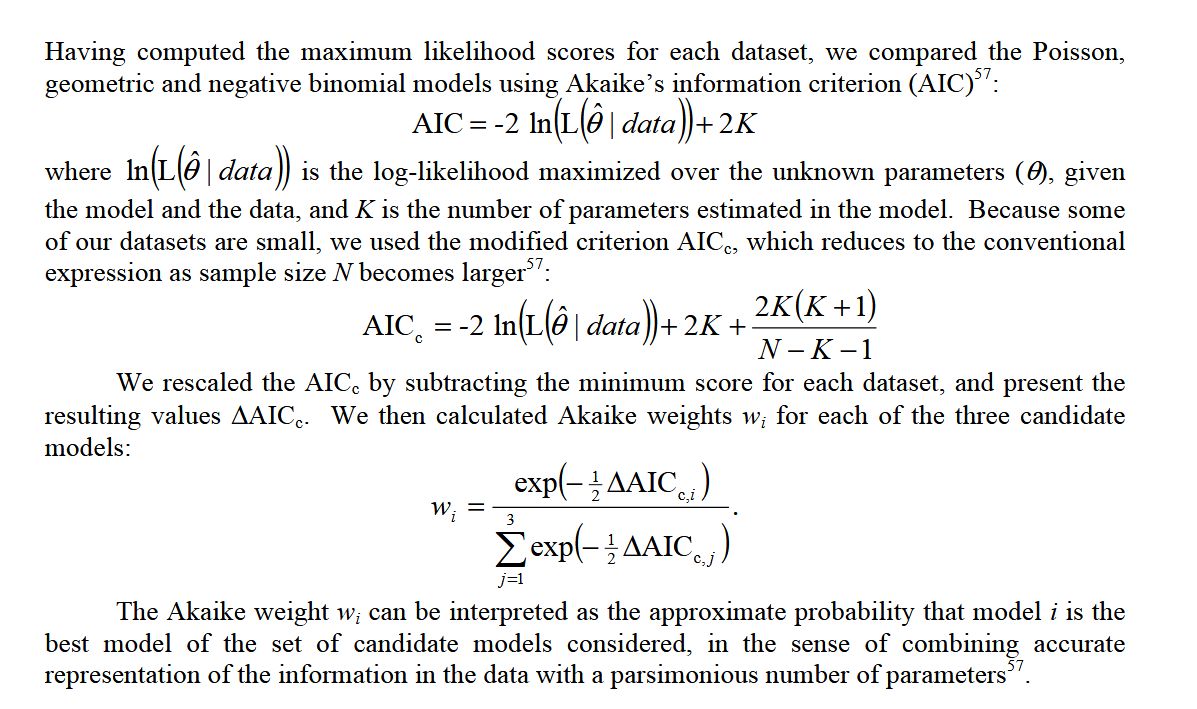

This notebook will re-implement the same technique.

To start, generate some data using the Scipy NegBinom, Geom, Poisson distributions. The effectiveness of this GOF technique should show that the correct distribution is chosen each time.

To begin with, use just the standard PMF functions in SciPy, then test the same using the reparameterised NegBinom PMF.

Experiment:
- Generate 3 sets of data (Poisson, NegBinom, Geometric)
- Fit the 3 distributions to each set of set of data. There should be $ 3^3 $ fits.
- For each of those, compute the AIC calculation that was shared by Lloyd-Smith and others.
- Poisson should be the best fit to Poisson-generated data, for example. Poisson being the best fit to NegBinom-generated data, for example, would be unexpected.
- Test that two parameterisations of NBinom should have roughly the same

In [14]:
# As in a previous notebook, need to patch nbinom so MLE will accept non-integer n

from scipy.optimize import differential_evolution
from scipy.stats._discrete_distns import nbinom_gen, _ShapeInfo
from scipy.stats import fit

class PatchedNBinom(nbinom_gen):
    def _shape_info(self):
        # in Shapeinfo we specify 'n' as non-integer
        return [_ShapeInfo("n", False, (0, np.inf), (True, False)),
                _ShapeInfo("p", False, (0, 1), (True, True))]

def optimizer(fun, bounds, *, integrality):
    return differential_evolution(fun, 
                                  bounds, 
                                  strategy='best2bin',
                                  integrality=[False, False, False])

nbinom = PatchedNBinom(name = 'nbinom')

In [28]:
from scipy.stats import geom, poisson, fit
import numpy as np

n=5.5
p=0.5
nbinom_data = nbinom.rvs(n=n, p=p, size = 50000)

mu=2
poisson_data = poisson.rvs(mu=mu, size = 50000)

p=0.9
geom_data = geom.rvs(p=p, size = 50000)

nbinom_fit_nbinom_data = fit(nbinom, nbinom_data, ((0, 100),(0.01, 100)))
nbinom_fit_poisson_data = fit(nbinom, poisson_data, ((0, 100),(0.01, 100)))
nbinom_fit_geom_data = fit(nbinom, geom_data, ((0, 100),(0.01, 100)))
poisson_fit_nbinom_data = fit(poisson, nbinom_data, [(0, 100)])
poisson_fit_poisson_data = fit(poisson, poisson_data, [(0, 100)])
poisson_fit_geom_data = fit(poisson, geom_data, [(0, 100)])
geom_fit_nbinom_data = fit(geom, nbinom_data, [(0, 1)])
geom_fit_poisson_data = fit(geom, poisson_data, [(0, 1)])
geom_fit_geom_data = fit(geom, geom_data, [(0, 1)])

In [29]:
print("{} fit to {} data gives params {}".format("nbinom", "nbinom", nbinom_fit_nbinom_data.params))
print("{} fit to {} data gives params {}".format("nbinom", "poisson", nbinom_fit_poisson_data.params))
print("{} fit to {} data gives params {}".format("nbinom", "geom", nbinom_fit_geom_data.params))

print("{} fit to {} data gives params {}".format("poisson", "nbinom", poisson_fit_nbinom_data.params))
print("{} fit to {} data gives params {}".format("poisson", "poisson", poisson_fit_poisson_data.params))
print("{} fit to {} data gives params {}".format("poisson", "geom", poisson_fit_geom_data.params))

print("{} fit to {} data gives params {}".format("geom", "nbinom", geom_fit_nbinom_data.params))
print("{} fit to {} data gives params {}".format("geom", "poisson", geom_fit_poisson_data.params))
print("{} fit to {} data gives params {}".format("geom", "geom", geom_fit_geom_data.params))

nbinom fit to nbinom data gives params FitParams(n=np.float64(5.48852758206089), p=np.float64(0.09996826535287978), loc=np.float64(0.0))
nbinom fit to poisson data gives params FitParams(n=np.float64(40.24572916599091), p=np.float64(0.9527948630126006), loc=np.float64(0.0))
nbinom fit to geom data gives params FitParams(n=np.float64(99.57819157578652), p=np.float64(0.9889625012993359), loc=np.float64(0.0))
poisson fit to nbinom data gives params FitParams(mu=np.float64(49.4142722392501), loc=np.float64(0.0))
poisson fit to poisson data gives params FitParams(mu=np.float64(1.9939199460618273), loc=np.float64(0.0))
poisson fit to geom data gives params FitParams(mu=np.float64(1.1113599935133809), loc=np.float64(0.0))
geom fit to nbinom data gives params FitParams(p=np.float64(0.02025147552540152), loc=np.float64(0.0))
geom fit to poisson data gives params FitParams(p=np.float64(0.43319801091196186), loc=np.float64(0.0))
geom fit to geom data gives params FitParams(p=np.float64(0.90042389

In [30]:
# Note that np.log(np.prod(nbinom.pmf(data,n=n,p=p))) == np.sum(np.log(nbinom.pmf(data,n=n,p=p)))

def AIC_c(data, dist, params):
    k = len(params)
    n = len(data)
    log_lik = dist.logpmf(data,*params).sum()
    AIC = 2*k - 2*log_lik
    AIC_c = AIC + (2*k*(k+1))/(n - k - 1)
    return (AIC_c - min(data))

print( AIC_c(nbinom_data, nbinom, [nbinom_fit_nbinom_data.params.n, nbinom_fit_nbinom_data.params.p]) )
print( AIC_c(nbinom_data, poisson, [poisson_fit_nbinom_data.params.mu]) )
print( AIC_c(nbinom_data, geom, [geom_fit_nbinom_data.params.p]) )

print( AIC_c(poisson_data, nbinom, [nbinom_fit_poisson_data.params.n, nbinom_fit_nbinom_data.params.p]) )
print( AIC_c(poisson_data, poisson, [poisson_fit_poisson_data.params.mu]) )
print( AIC_c(poisson_data, geom, [geom_fit_poisson_data.params.p]) )

print( AIC_c(geom_data, nbinom, [nbinom_fit_geom_data.params.n, nbinom_fit_nbinom_data.params.p]) )
print( AIC_c(geom_data, poisson, [poisson_fit_geom_data.params.mu]) )
print( AIC_c(geom_data, geom, [geom_fit_geom_data.params.p]) )

445664.13391091477
769209.0136897066
inf
8656381.430162612
170548.69912829794
inf
22440331.175145578
107592.51275635541
36178.8561635954


It would be interesting to see how well the reparameterised nbimon fits data generated by Scipy's nbinom, and the other way too.

In [44]:
from math import gamma, factorial
from scipy.stats import fit, rv_discrete
from scipy.stats._distn_infrastructure import _ShapeInfo

class NbinomReparameterisedReciprocal(rv_discrete):

    def _pmf(self, x, m, k):
        pmf_values = []

        if isinstance(m, np.ndarray):
            m = m[0] # an array all the same for n, p
        if isinstance(k, np.ndarray):
            k = k[0]

        # The article by Lloyd-Smith et al says it's more reliable to fit the reciprocal of k, alpha=1/k, and then convert it back later
        # But the issues with homogeneous data only happens with k>1
        
        alpha = 1/k
            
        # the standard method seems to use a np array, but I couldn't get it to work. So, verbosely use each element
        for x_i in x:
            if not isinstance(x, int):
                x_i = int(x_i)
            pmf_i = (1+m/alpha)**(-alpha) * (gamma(alpha+x_i)/(factorial(x_i)*gamma(alpha))) * (m/(m+alpha))**x_i
            pmf_values.append(pmf_i)
        return pmf_values
    
    def _argcheck(self, m, k):
        m_check = 0 < m
        k_check = 0 < k
        # there's no reason to assume that k would be less than one in this parameterisation
        return m_check & k_check

    def _param_info(self):
        # required to work with MLE in scipy.stats.fit
        return [_ShapeInfo("m", False, (0, np.inf), (True, False)),
                _ShapeInfo("k", False, (0, np.inf), (True, False)),
                _ShapeInfo("loc", False, (0, np.inf), (True, True))]
    
nbinom_reparam_reciprocal = NbinomReparameterisedReciprocal(name='NbinomReparameterisedReciprocal')

In [19]:
def get_delta_AIC_c(data, dist, params):
    k = len(params)
    n = len(data)
    log_lik = dist.logpmf(data,*params).sum()
    AIC = 2*k - 2*log_lik
    AIC_c = AIC + (2*k*(k+1))/(n - k - 1)
    delta_AIC_c = AIC_c - min(data)
    return delta_AIC_c

In [92]:
n=2
p=0.5
scipy_nbinom_data = nbinom.rvs(n, p, size = 5000)

m=0.3 # m=k will mean this is the poisson distribution
k=0.3
nbinom_reparam_data = nbinom_reparam_reciprocal.rvs(m, k, size = 5000)

In [93]:
scipy_nbinom_fit_scipy_nbinom_data     = fit(nbinom,                    scipy_nbinom_data, ((0, 100),(0.01, 100)))
scipy_nbinom_fit_nbinom_reparam_data   = fit(nbinom,                    nbinom_reparam_data, ((0, 100),(0.01, 100)))
print("{} fit to {} data gives params {}".format("scipy nbinom", "scipy nbinom", scipy_nbinom_fit_scipy_nbinom_data.params))
print("{} fit to {} data gives params {}".format("scipy nbinom", "reparam nbinom", scipy_nbinom_fit_nbinom_reparam_data.params))

scipy nbinom fit to scipy nbinom data gives params FitParams(n=np.float64(2.0734177542676497), p=np.float64(0.5042085112592891), loc=np.float64(0.0))
scipy nbinom fit to reparam nbinom data gives params FitParams(n=np.float64(4.477943986625614), p=np.float64(0.9405184894114684), loc=np.float64(0.0))


In [94]:
nbinom_reparam_fit_scipy_nbinom_data   = fit(nbinom_reparam_reciprocal, scipy_nbinom_data, ((0, 50),(0.05, 20)))
nbinom_reparam_fit_nbinom_reparam_data = fit(nbinom_reparam_reciprocal, nbinom_reparam_data, ((0, 50),(0.05, 20)))
print("{} fit to {} data gives params {}".format("reparam nbinom", "scipy nbinom", nbinom_reparam_fit_scipy_nbinom_data.params))
print("{} fit to {} data gives params {}".format("reparam nbinom", "reparam nbinom", nbinom_reparam_fit_nbinom_reparam_data.params))

reparam nbinom fit to scipy nbinom data gives params FitParams(m=np.float64(2.04747603117546), k=np.float64(0.4790333946592984), loc=np.float64(0.0))
reparam nbinom fit to reparam nbinom data gives params FitParams(m=np.float64(0.2922847675452118), k=np.float64(0.16496275144497652), loc=np.float64(0.0))


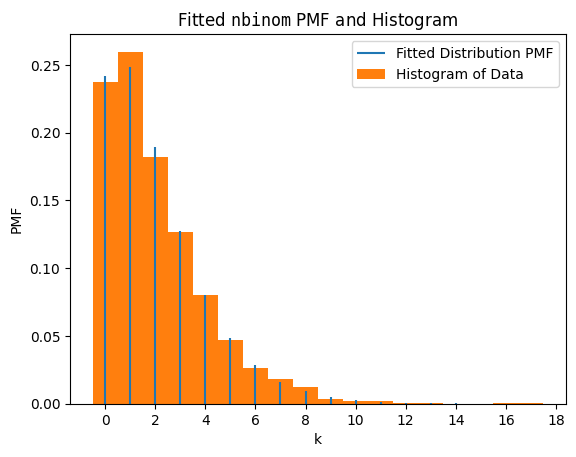

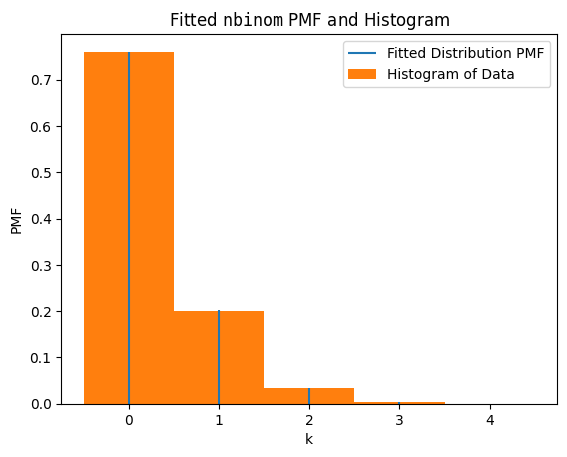

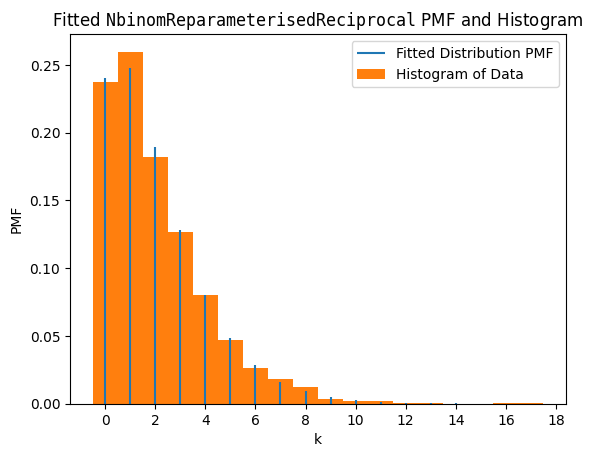

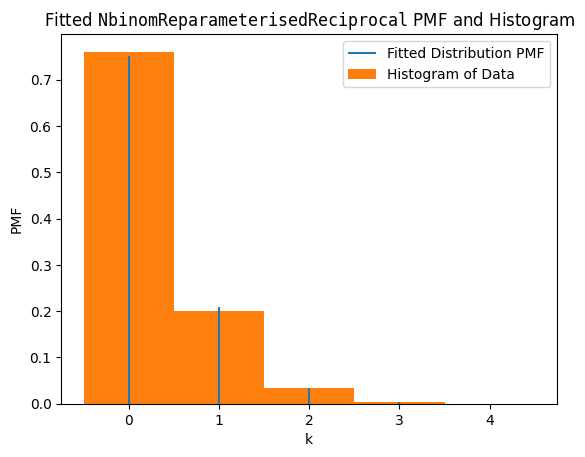

In [95]:
import matplotlib.pyplot as plt

plt.figure()
scipy_nbinom_fit_scipy_nbinom_data.plot()
plt.show()
plt.figure()
scipy_nbinom_fit_nbinom_reparam_data.plot()
plt.show()

plt.figure()
nbinom_reparam_fit_scipy_nbinom_data.plot()
plt.show()
plt.figure()
nbinom_reparam_fit_nbinom_reparam_data.plot()
plt.show()


In [85]:
print( get_delta_AIC_c(scipy_nbinom_data,   nbinom,                    [scipy_nbinom_fit_scipy_nbinom_data.params.n,       scipy_nbinom_fit_scipy_nbinom_data.params.p]) )
print( get_delta_AIC_c(nbinom_reparam_data, nbinom,                    [scipy_nbinom_fit_nbinom_reparam_data.params.n,     scipy_nbinom_fit_nbinom_reparam_data.params.p]) )
print( get_delta_AIC_c(scipy_nbinom_data,   nbinom_reparam_reciprocal, [nbinom_reparam_fit_scipy_nbinom_data.params.m,     nbinom_reparam_fit_scipy_nbinom_data.params.k]) )
print( get_delta_AIC_c(nbinom_reparam_data, nbinom_reparam_reciprocal, [nbinom_reparam_fit_nbinom_reparam_data.params.m,   nbinom_reparam_fit_nbinom_reparam_data.params.k]) )

12528.851637813177
6832.342683818069
12528.851631891128
6832.270302266901


This is a bit suspicious to find that both distributions fit the scipy-generated data equally well, but then the same again for the reparameterised-generated data also. This does at least confirm that the two distributions have no noticeable difference, but why is it that one dataset has a lower AIC than the other? Is it because those datasets are better suited to some other distribution, like Poisson or Geom?

In [96]:
poisson_fit_scipy_nbinom_data = fit(poisson, scipy_nbinom_data, [(0, 100)])
poisson_fit_reparam_nbinom_data = fit(poisson, nbinom_reparam_data, [(0, 100)])
geom_fit_scipy_nbinom_data = fit(geom, scipy_nbinom_data, [(0, 1)])
geom_fit_reparam_nbinom_data = fit(geom, nbinom_reparam_data, [(0, 1)])

print("scipy_nbinom_data")
print("poisson.......", get_delta_AIC_c(scipy_nbinom_data,   poisson,                   [poisson_fit_scipy_nbinom_data.params.mu]) )
print("geom..........", get_delta_AIC_c(scipy_nbinom_data,   geom,                      [geom_fit_scipy_nbinom_data.params.p]) )
print("scipy nbinom..", get_delta_AIC_c(scipy_nbinom_data,   nbinom,                    [scipy_nbinom_fit_scipy_nbinom_data.params.n,       scipy_nbinom_fit_scipy_nbinom_data.params.p]) )
print("reparam nbinom", get_delta_AIC_c(scipy_nbinom_data,   nbinom_reparam_reciprocal, [nbinom_reparam_fit_scipy_nbinom_data.params.m,     nbinom_reparam_fit_scipy_nbinom_data.params.k]) )
print("...")
print("nbinom_reparam_data")
print("poisson.......", get_delta_AIC_c(nbinom_reparam_data, poisson,                   [poisson_fit_reparam_nbinom_data.params.mu]) )
print("geom..........", get_delta_AIC_c(nbinom_reparam_data, geom,                      [geom_fit_reparam_nbinom_data.params.p]) )
print("scipy nbinom..", get_delta_AIC_c(nbinom_reparam_data, nbinom,                    [scipy_nbinom_fit_nbinom_reparam_data.params.n,     scipy_nbinom_fit_nbinom_reparam_data.params.p]) )
print("reparam nbinom", get_delta_AIC_c(nbinom_reparam_data, nbinom_reparam_reciprocal, [nbinom_reparam_fit_nbinom_reparam_data.params.m,   nbinom_reparam_fit_nbinom_reparam_data.params.k]) )

scipy_nbinom_data
poisson....... 20250.624783052655
geom.......... inf
scipy nbinom.. 18918.95158774807
reparam nbinom 18919.067827882085
...
nbinom_reparam_data
poisson....... 6729.682653927671
geom.......... inf
scipy nbinom.. 6723.120520838101
reparam nbinom 6724.987525815797
